This file is to find the ideal integration slice size for the power law relationship when each integration step is convolved with the actual absorption from the detector. 

In [0]:
from math import sqrt, sin
from cmath import pi
import numpy 
from pylab import *
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import integrate 
from scipy.interpolate import interp1d
import pandas as pd

In [78]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [79]:
#fixed variables
k_B = 8.617333262145e-5 #eV K^{-1}
h = 4.135667696e-15 #eV * s
c = 299792458 #m / s
eV_to_J = 1.602176565e-19 

#modifiable variables
r_rad_small = 0.001 #m -radius of radiator
r_abs = 0.001 #m -radius of absorber
d =  0.1 #m -distance between absorber and radiator


#Filter with a passband between E_1 and E_2 #Filter with a passband between E_1 and E_2 
v_min = 1e2 #Hz ( 1e-9 THz)
v_max = 1e16 #Hz (10000 THz)

E_min = v_min*h #eV 
E_max = v_max*h #eV 

Temps_range = np.arange(300,2000,50) #last element is "slice size"
                   
print("The energy window is ", E_min, " eV to ", E_max, " eV.")
print("The integration limits are ", E_min/(k_B * 0.1), "  to ", E_max/(k_B * 0.1))

The energy window is  4.1356676960000005e-13  eV to  41.35667696  eV.
The integration limits are  4.799243072294227e-08   to  4799243.072294227


In [0]:
def gamma_0(T, r_rad):  
    area = pi * r_abs**2
    sin_theta = r_rad /sqrt(r_rad**2 + d**2)
    return area*sin_theta * (8 * pi * (k_B * T)**2)/(h**3 * c**2)

In [0]:
#function to integrate via Sumpson's rule
#Noah's modifications to be overflow safe
def power_integral(x):
    #if we have a list, convert to numpy array
    if(type(x)==list):
        x = numpy.array(dtype=numpy.float128)
        
    #if we have a numpy array, proceed
    if(type(x)== numpy.ndarray):
        retvals = numpy.zeros_like(x,dtype=numpy.float128)
        inds = x < 1e3
        #small values can be directly calculated
        retvals[inds] = x[inds]**3/(numpy.exp(x[inds])-1.0)
        #in the limit of large x, f(x)~exp(-x)
        retvals[~inds] = numpy.exp(-x[~inds])
        return retvals
    
    #assume we have a number
    else: 
        if(type(x)!='float128'):
            x=numpy.float128(x)
        if(x>1e3):
            return numpy.exp(-x)
        else:
            return x**3/(numpy.exp(x)-1.0)

In [0]:
#a is lower lim, b is upper lim, n is number of slices
def simpson(g, a, b, n, T): 
    h=(b-a)/n
    k=0.0
    x=a + h
    for i in arange(1,n/2 + 1):
        k += 4*g(x, T)
        x += 2*h
    x = a + 2*h
    for i in arange(1,n/2):
        k += 2*g(x, T)
        x += 2*h
    r = (h/3)*(g(a, T)+g(b, T)+k)
    return r

In [0]:
#this function returns the constant adjustment to power, given Temperature and r_rad
def power_func(T, r_rad):
  return eV_to_J * k_B**2 * T**2 * gamma_0(T, r_rad) 

In [0]:
#extract absoprtion curve of detector, from detector documentation. Must have detector information stored in the following path in order to run
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'

absorption_data = pd.read_csv(folder_path + "AbsorptionCurve.csv")
wavelengths = absorption_data["wavelength"]
absorption = absorption_data["absorption"]

In [0]:
#convert wavlength in micron to frequencies 
micron_to_m = 1e-6
c = 3e8
frequencys = c / (wavelengths * micron_to_m)

frequencys = frequencys[::-1]
absorption = absorption[::-1]

#interpolate the absorption function to get points at all frequencies
absorption_function = interp1d(frequencys, absorption, fill_value='extrapolate')


In [0]:
#integrable function that gives covolution of absorption which varies with frequency and the power integral 
#limits of integration (x) must be in units energy (eV)
def adjusted_power_integrable(x,T):
  return power_integral(x/(k_B * T)) * absorption_function(x/h)

#using the integrate.quad function, get the full adjusted power for a given temperature 
def get_adjusted_power(T, n):
  integral_value = simpson(adjusted_power_integrable, E_min, E_max, n, T)
  power_value = integral_value*power_func(T, r_rad_small)
  return power_value

  #using the integrate.quad function, get the full adjusted power for a given temperature 
def get_adjusted_power_quad(T):
  integral_value, err = integrate.quad(adjusted_power_integrable, E_min, E_max, args=(T,))
  power_value = integral_value*power_func(T, r_rad_small)
  return power_value

This function calculates the power law for the number of integration slices used. Uses the framework (which is plotted with raw data and log form to show fit in file PowerLawRelationship)

In [0]:
def power_law_for_number(n):
  slice_size = (v_max - v_min)/n
  freq = np.arange(v_min, v_max, slice_size)

  powers = [] #to contain one integrated power measurment at each temp
  for i in range(0,len(Temps_range)):
    power_value = get_adjusted_power(Temps_range[i], n)
    powers.append(power_value)
  fit = numpy.poly1d(numpy.polyfit(np.log10(Temps_range.astype("float64")), numpy.log10(numpy.asarray(powers, dtype=numpy.float64)), 1 ))
  power_law = fit[1]
  return power_law

In [88]:
#number_of_slices = arange(5, 100, 5)
number_of_slices = [80, 90, 100, 150, 200, 300, 400, 500, 600, 700, 800, 1000, 2000, 10000]
power_law = []
for i in range(len(number_of_slices)):
  print("the number of integration slices running at this time are: " , number_of_slices[i])
  power_law.append(power_law_for_number(number_of_slices[i]))

the number of integration slices running at this time are:  80
the number of integration slices running at this time are:  90
the number of integration slices running at this time are:  100
the number of integration slices running at this time are:  150
the number of integration slices running at this time are:  200
the number of integration slices running at this time are:  300
the number of integration slices running at this time are:  400
the number of integration slices running at this time are:  500
the number of integration slices running at this time are:  600
the number of integration slices running at this time are:  700
the number of integration slices running at this time are:  800
the number of integration slices running at this time are:  1000
the number of integration slices running at this time are:  2000
the number of integration slices running at this time are:  10000


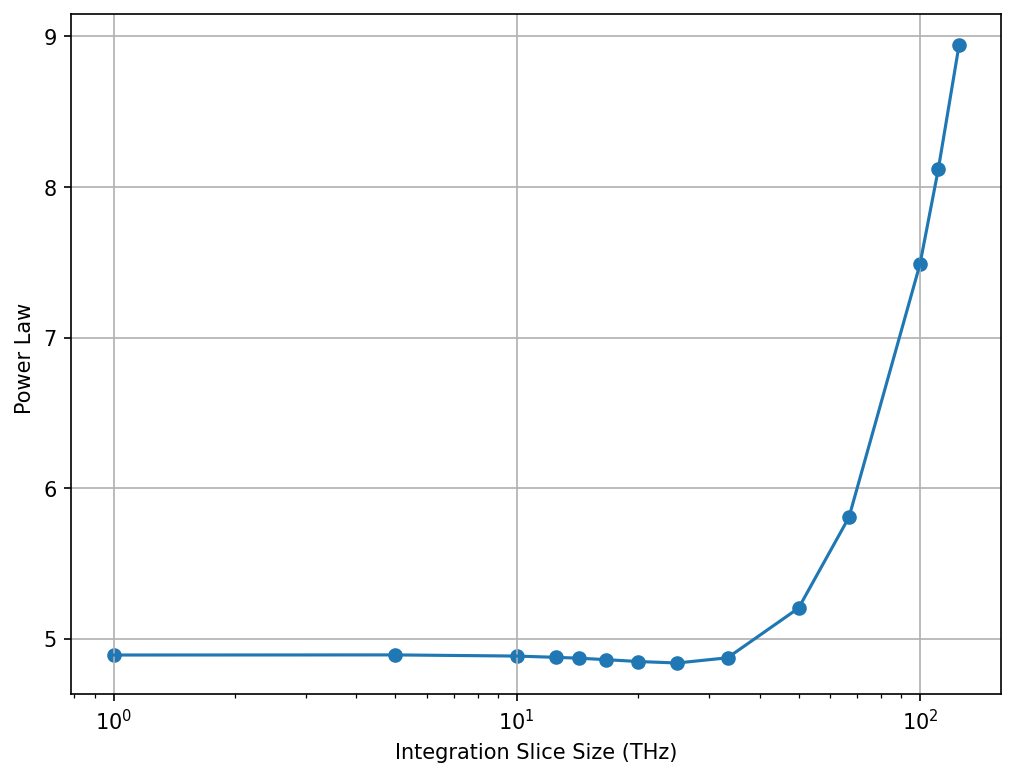

In [89]:
slice_sizes = (v_max - v_min)/np.asarray(number_of_slices)
frequency_slices = slice_sizes /1e12

fig = plt.figure(figsize=(8, 6), dpi=150)
plt.scatter(frequency_slices, power_law)
plt.plot(frequency_slices, power_law)
title = "Power Law of linear fit as a function of integration slice size \n for integrated power convolved with Detector Absorption Rate"
plt.ylabel("Power Law ")
plt.xscale("log")
plt.xlabel("Integration Slice Size (THz)")
plt.grid(True)
plt.show()

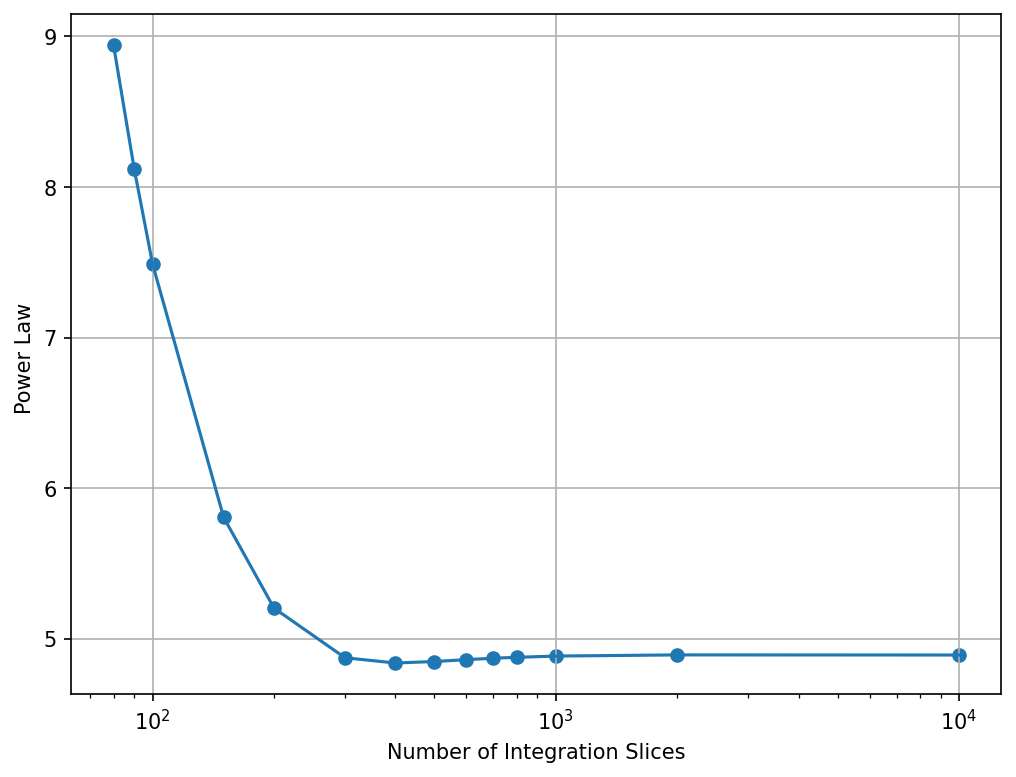

In [90]:
fig = plt.figure(figsize=(8, 6), dpi=150)
plt.scatter(number_of_slices, power_law)
plt.plot(number_of_slices, power_law)
title = "Power Law of linear fit as a function of number of integration slices \n for integrated power convolved with Detector Absorption Rate"
plt.ylabel("Power Law ")
plt.xscale("log")
plt.xlabel("Number of Integration Slices")
plt.grid(True)
plt.show()

In [97]:
print("the powerlaw converges to ", power_law[-1], " using by hand integration function ")

the powerlaw converges to  4.890570282847488  using by hand integration function 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if sys.path[0] == '':


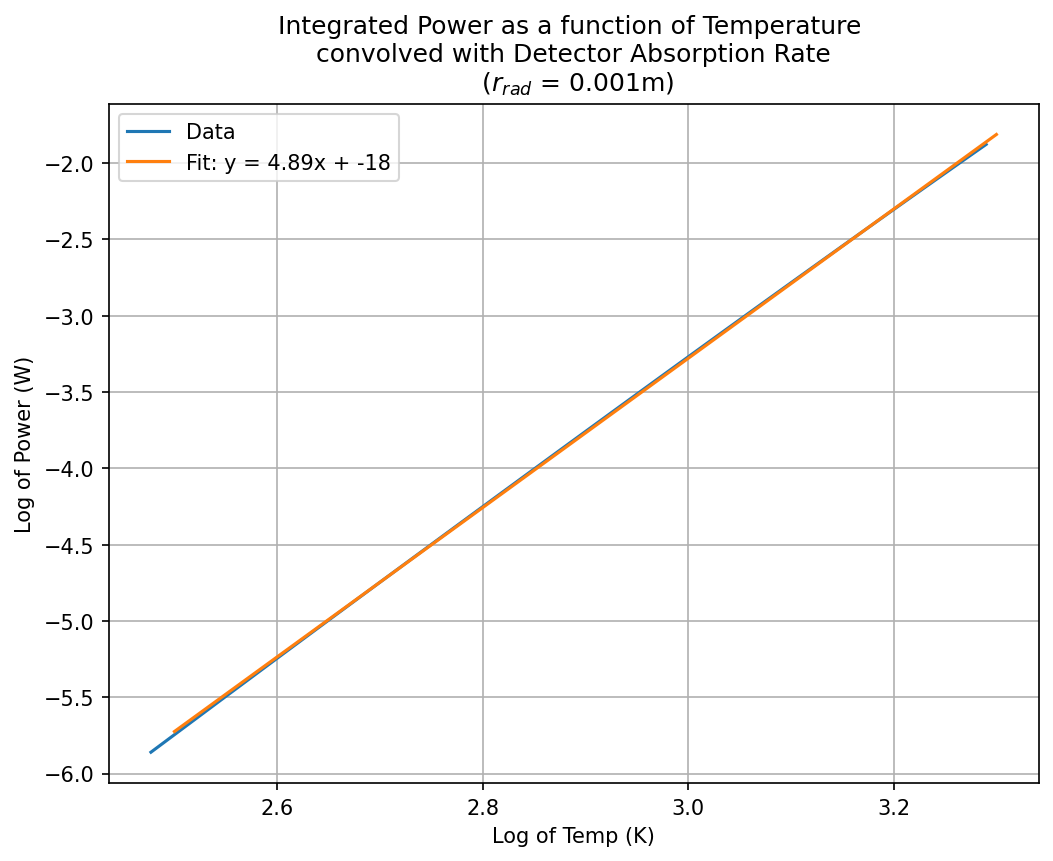

In [96]:

powers = [] #to contain one integrated power measurment at each temp
for i in range(0,len(Temps_range)):
  power_value = get_adjusted_power_quad(Temps_range[i])
  powers.append(power_value)


fit = numpy.poly1d(numpy.polyfit(np.log10(Temps_range.astype("float64")), numpy.log10(numpy.asarray(powers, dtype=numpy.float64)), 1 ))
fit_string = 'Fit: y = {0:.3g}x + {1:.3g}'.format(fit[1], fit[0])
t = np.linspace(2.5, 3.3, 100)


fig = plt.figure(figsize=(8, 6), dpi=150)
plt.plot(numpy.log10(Temps_range), numpy.log10(powers), label = 'Data')
plt.plot(t, fit(t), label = fit_string)
title_power_T = "Integrated Power as a function of Temperature \n convolved with Detector Absorption Rate \n ($r_{rad}$ = " + str(r_rad_small) +  "m)"
plt.title(title_power_T)
plt.ylabel("Log of Power (W)")
plt.xlabel("Log of Temp (K)")
plt.grid(True)
plt.legend()
plt.show()
